(dl/04-sequence-models/04cd-wavenet)=
# Temporal / Causal convolutions

One problem with our previous network is that sequential information from the inputs are mixed or squashed too fast (i.e. in one layer). We can make this network deeper by adding dense layers, but it still does not solve this problem. In this section, we implement a convolutional neural network architecture similar to **WaveNet** {cite}`wavenet`. This allows the character embeddings to be fused slowly.

```{figure} ../../../img/nn/04-wavenet.png
---
width: 700px
name: wavenet
---
{cite}`wavenet` Tree-like structure formed by a stack of dilated *causal* convolutional layers. The term causal is used since the network is constrained so that an output node at position `t` can only depend on input nodes at position `t-k:t`.
```

The structure of the network allows us to use a larger block size. 
Previously, increasing block size by 1 means that the network 
width increases 
equal to the embedding dimension.
For this network, the width is fixed but we have to increase depth.

In [1]:
from chapter import *

In [2]:
PAD_TOKEN = "."
BLOCK_SIZE = 8  # !
names = load_surnames()
vocab = Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])
split_point = int(0.80 * len(names))

train_dataset = CharDataset(names[:split_point], block_size=BLOCK_SIZE, vocab=vocab)
valid_dataset = CharDataset(names[split_point:], block_size=BLOCK_SIZE, vocab=vocab)

for x, y in zip(train_dataset.xs, train_dataset.ys):
    print("".join(x), "-->", y)
    if y == PAD_TOKEN: 
        break

........ --> d
.......d --> u
......du --> r
.....dur --> a
....dura --> n
...duran --> a
..durana --> .


To implement this without using dilated convolutions, we define the following class 
so that only two characters are combined at each step. The linear layer is applied to 
the last dimension which the following layer expands. Here `n` corresponds to the number 
of characters that are combined at each step.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class FlattenConsecutive(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.n = n
    
    def forward(self, x):
        B, T, C = x.shape   # (batch, char, emb)
        x = x.view(B, T // self.n, C * self.n)
        return x

To see how this works:

In [4]:
B, T, C = 2, 4, 2
x = torch.rand(B, T, C)
x

tensor([[[0.8823, 0.9150],
         [0.3829, 0.9593],
         [0.3904, 0.6009],
         [0.2566, 0.7936]],

        [[0.9408, 0.1332],
         [0.9346, 0.5936],
         [0.8694, 0.5677],
         [0.7411, 0.4294]]])

In [5]:
x.view(B, T // 2, C * 2)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936]],

        [[0.9408, 0.1332, 0.9346, 0.5936],
         [0.8694, 0.5677, 0.7411, 0.4294]]])

Information from characters can flow better through the network due to its hierarchical nature. 
Hence, we increase embedding size, network width, as well as make the network is deeper. 
Note that we need three layers to combine all characters, i.e. 2 × 2 × 2 = 8 (block size). Stride happens in the way character blocks are fed to the layers, so convolutions need not be explicitly used. The resulting network resembles our previous network:

In [6]:
from torch.optim.lr_scheduler import OneCycleLR

emb_size = 24
width = 128
DEVICE = "mps"
VOCAB_SIZE = len(vocab)
BATCH_SIZE = 128

wavenet = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, emb_size),
    FlattenConsecutive(2), nn.Linear(emb_size * 2, width), nn.ReLU(),
    FlattenConsecutive(2), nn.Linear(   width * 2, width), nn.ReLU(),
    FlattenConsecutive(2), nn.Linear(   width * 2, width), nn.ReLU(),
    nn.Linear(width, VOCAB_SIZE), nn.Flatten()  # flatten: rank 3 -> rank 2
)

epochs = 5
wavenet = wavenet.to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(wavenet.parameters(), lr=0.0001)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)
trainer = Trainer(wavenet, optim, loss_fn, scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=train_loader, valid_loader=valid_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1/5]    loss: 2.3225    val_loss: 2.3445
[Epoch: 2/5]    loss: 2.3095    val_loss: 2.3015
[Epoch: 3/5]    loss: 2.2240    val_loss: 2.2191
[Epoch: 4/5]    loss: 2.1433    val_loss: 2.1659
[Epoch: 5/5]    loss: 2.0703    val_loss: 2.1520


**Remark.** Finally broke through 2.3 loss!

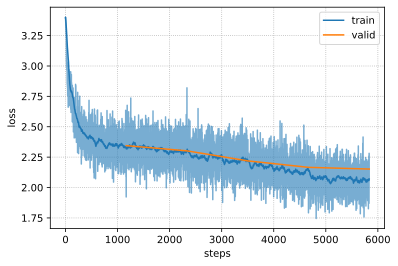

In [7]:
from matplotlib.ticker import StrMethodFormatter

num_epochs = len(trainer.valid_log["loss"])
num_steps_per_epoch = len(trainer.train_log["loss"]) // num_epochs

a = np.array(trainer.train_log["loss_avg"])[0] + 0.1
b = np.array(trainer.train_log["loss_avg"])[-1] - 0.1
plt.figure(figsize=(6, 4))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}")) # 2 decimal places
plt.plot(np.array(trainer.train_log["loss"]), alpha=0.6, color="C0")
plt.ylabel("loss")
plt.xlabel("steps")
plt.plot(np.array(trainer.train_log["loss_avg"]), color="C0", label="train")
plt.plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["loss"], label="valid", color="C1")
plt.grid(linestyle="dotted")
plt.legend();

The generated names look very natural:

In [8]:
for _ in range(10):
    n = generate_name(lambda x: F.softmax(wavenet.to("cpu")(x), dim=1), train_dataset, seed=_)
    print(n)

perez_de_mengagos
morin_siguereco
berham
bais
drakozi
mozar
gonzalez_palentona
goyache
lamran
banatz
